Epoch 0, Train Loss: 14199.830078125, Test Loss: 13509.78125
Epoch 500, Train Loss: 366.88824462890625, Test Loss: 355.43438720703125
Epoch 1000, Train Loss: 13.682121276855469, Test Loss: 16.562088012695312
Epoch 1500, Train Loss: 1.1676316261291504, Test Loss: 7.665529251098633
Epoch 2000, Train Loss: 0.3062519431114197, Test Loss: 2.5057594776153564
Epoch 2500, Train Loss: 0.08382592350244522, Test Loss: 0.8195264339447021
Epoch 3000, Train Loss: 0.022261440753936768, Test Loss: 0.29487788677215576
Epoch 3500, Train Loss: 0.008897846564650536, Test Loss: 0.15344923734664917


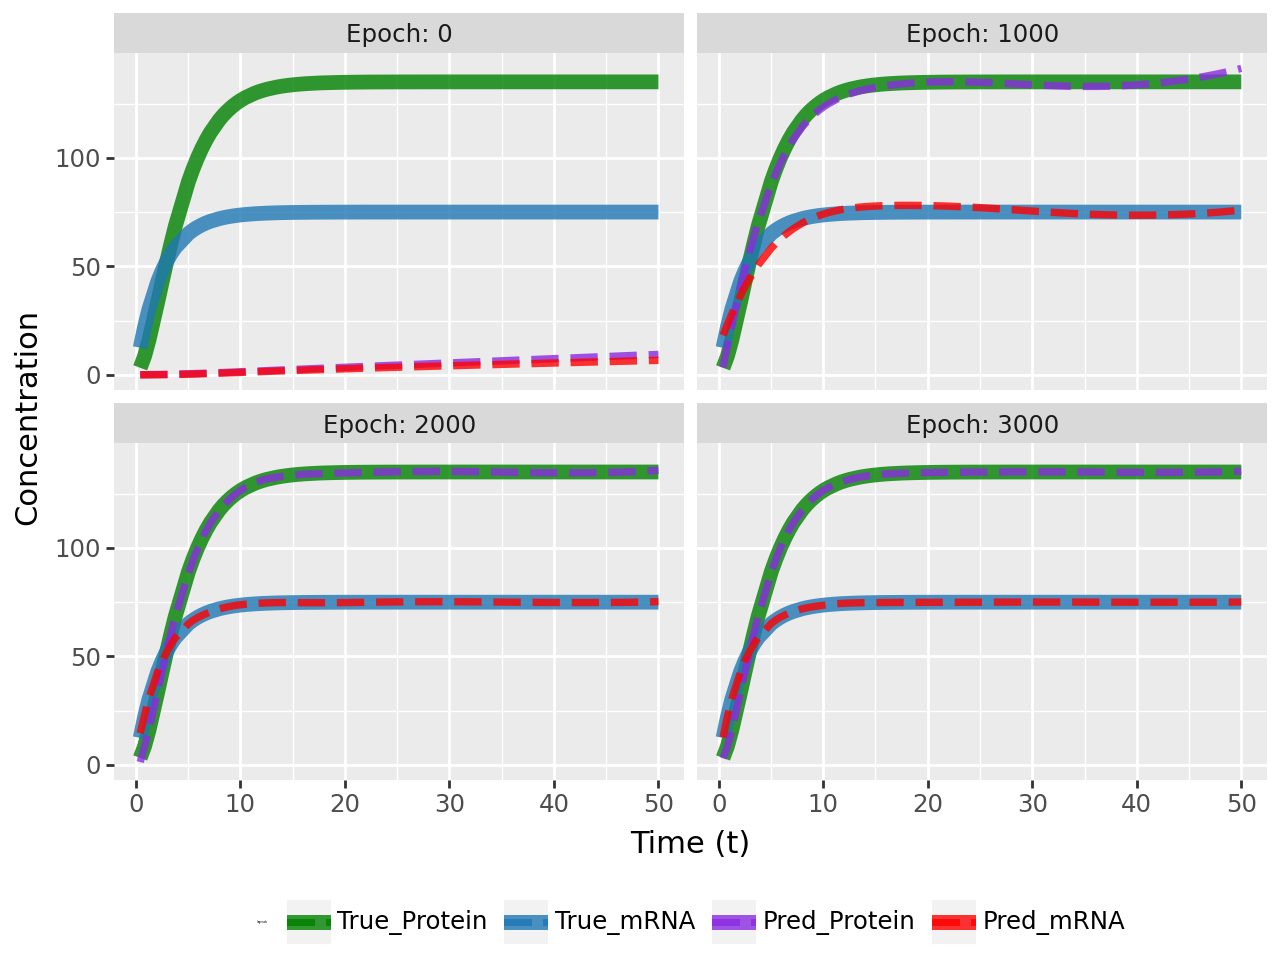

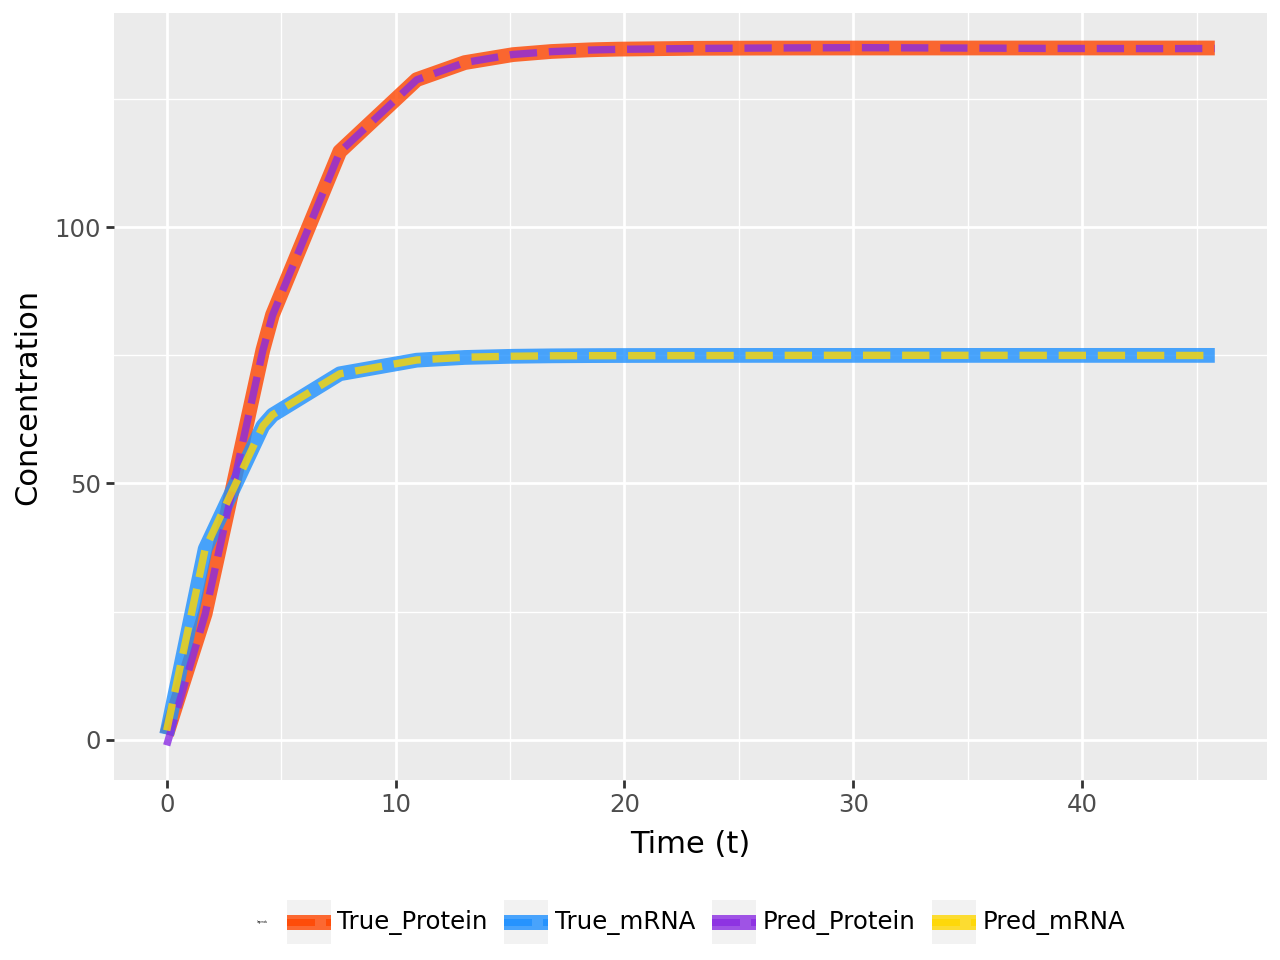

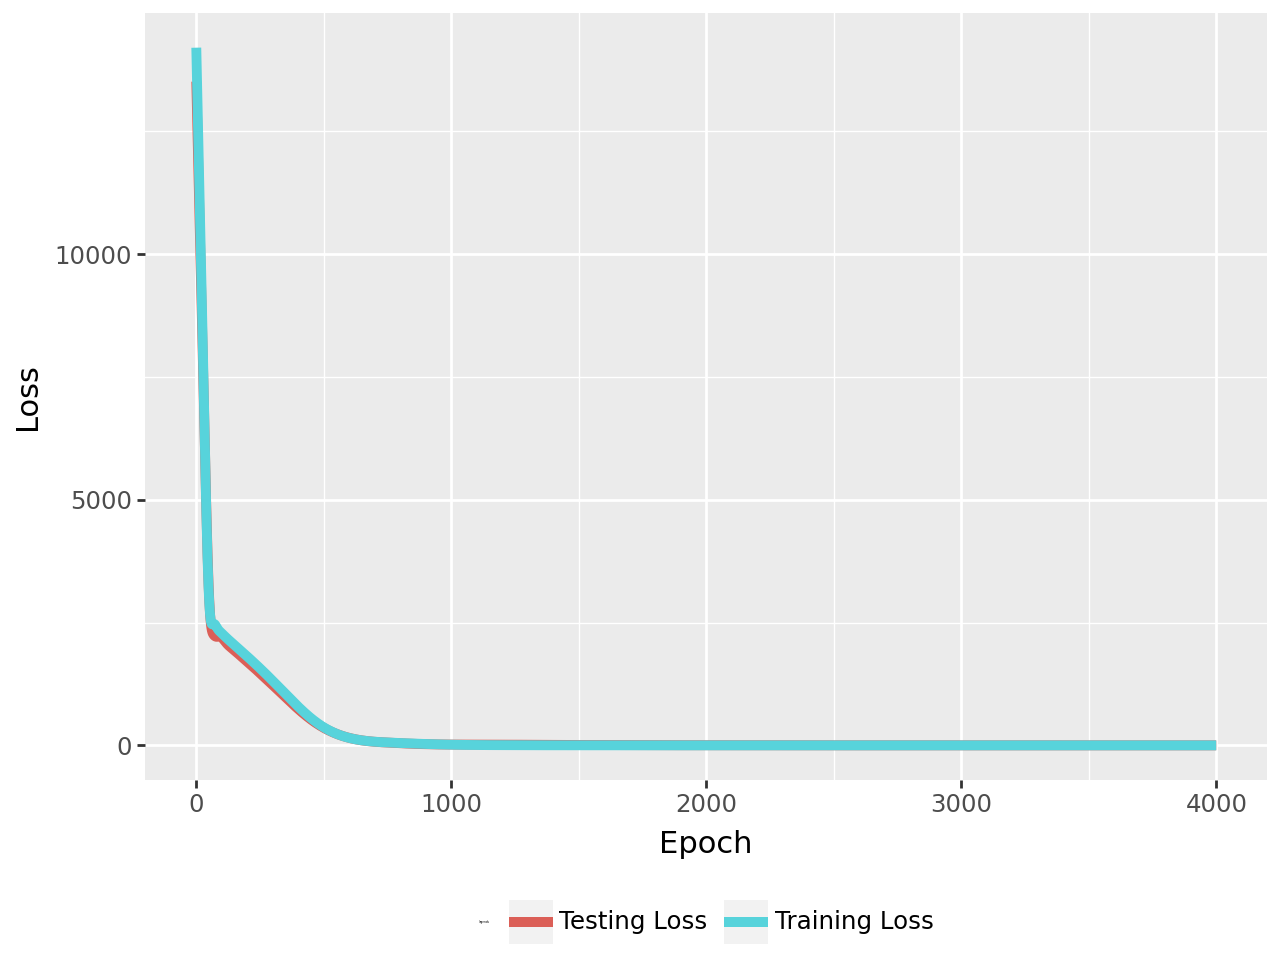

In [11]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from model import PINN
from data_utils import simulate_data, load_and_prepare_data
from train import prepare_dataloader, train_with_physics_loss
# from plot_utils import plot_training_results, plot_results
from GE_plot_utils import *

import warnings
warnings.filterwarnings("ignore")


# Convert data to PyTorch tensors
def to_tensor(x, device, requires_grad=False):
    return torch.tensor(x, dtype=torch.float32, requires_grad=requires_grad).to(device)

def main():
    ############################  Configuration Section ############################
    # Define parameters
    PN = 50  # Plasmid number
    k_m = 0.6  # Transcription rate
    gamma_m = 0.4  # mRNA degradation rate
    k_p = 0.9  # Translation rate
    gamma_p = 0.5  # Protein degradation rate
    T = 50   # Total simulation time
    num_samples = 120  # Number of samples for training data
    m0 = 1  # Initial mRNA
    p0 = 1  # Initial protein

    # Neural Network Configuration
    INPUT_DIM = 1
    HIDDEN_DIMS = [100,100]  # List of hidden layer sizes
    OUTPUT_DIM = 2  # Adjusted to match output dimensions

    activation_functions = [nn.Sigmoid, nn.Tanh, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.SELU, nn.Softmax, nn.LogSoftmax, nn.GELU]

    # Select activation function
    ACTIVATION_FN = activation_functions[8]  # GELU

    # Hyperparameters
    BATCH_SIZE = 32
    LR = 0.001  # Learning rate
    EPOCHS = 4000
    EPOCH_INTERVAL = 1000  # Interval for plotting and printing
    PATIENCE = 200  # Patience for early stopping

    # Simulate data
    t, m_data, p_data = simulate_data(PN, k_m, gamma_m, k_p, gamma_p, T, num_samples, m0, p0)

    # Load and prepare data
    t_train_set, t_test_set, data_m_train_set, data_p_train_set, data_m_test_set, data_p_test_set = load_and_prepare_data()

    # Convert data to PyTorch tensors
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    t_train_tensor = to_tensor(t_train_set, device, requires_grad=True)
    data_m_train_tensor = to_tensor(data_m_train_set, device)
    data_p_train_tensor = to_tensor(data_p_train_set, device)
    t_test_tensor = to_tensor(t_test_set, device, requires_grad=True)
    data_m_test_tensor = to_tensor(data_m_test_set, device)
    data_p_test_tensor = to_tensor(data_p_test_set, device)

    # Initialize model, optimizer, and DataLoader
    model = PINN(INPUT_DIM, HIDDEN_DIMS, OUTPUT_DIM, ACTIVATION_FN).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    train_loader = prepare_dataloader(t_train_set, data_m_train_set, data_p_train_set, batch_size=BATCH_SIZE, device=device)

    # Train the model
    history, train_losses, test_losses = train_with_physics_loss(
        model, optimizer, EPOCHS, PATIENCE, t_train_tensor, data_m_train_tensor, data_p_train_tensor,
        t_test_tensor, data_m_test_tensor, data_p_test_tensor, k_m, gamma_m, k_p, gamma_p, PN
    )


    # Plot results
    plots_interval = EPOCH_INTERVAL
    # plots_interval = EPOCHS
    if plots_interval == EPOCH_INTERVAL:
        epochs_to_plot = [i for i in range(0, EPOCHS, EPOCH_INTERVAL)]
        if epochs_to_plot:
            plot_training_results(t_train_set, data_m_train_set, data_p_train_set, history, epochs_to_plot)
            plot_testing_results(t_test_set, data_m_test_set, data_p_test_set, history, epochs_to_plot)
            plot_loss_curves(train_losses, test_losses)


if __name__ == "__main__":
    main()

Epoch 0, Loss: 15522.59375
Parameters: gamma_m: 0.9990000128746033, gamma_p: 0.9990000128746033, k_m: 0.9990000128746033, k_p: 0.9990000128746033
Epoch 500, Loss: 20.8126220703125
Parameters: gamma_m: 0.7697815299034119, gamma_p: 0.7085171937942505, k_m: 1.0947109460830688, k_p: 1.2791962623596191
Epoch 1000, Loss: 5.185791492462158
Parameters: gamma_m: 0.7387468218803406, gamma_p: 0.7022896409034729, k_m: 1.0905883312225342, k_p: 1.255876898765564
Epoch 1500, Loss: 3.7427048683166504
Parameters: gamma_m: 0.7255881428718567, gamma_p: 0.6862722039222717, k_m: 1.074137806892395, k_p: 1.2273578643798828
Epoch 2000, Loss: 4.0758209228515625
Parameters: gamma_m: 0.7087649703025818, gamma_p: 0.6635291576385498, k_m: 1.0480139255523682, k_p: 1.1874374151229858
Epoch 2500, Loss: 2.7397313117980957
Parameters: gamma_m: 0.6853653192520142, gamma_p: 0.6346979737281799, k_m: 1.0149235725402832, k_p: 1.1366983652114868
Epoch 3000, Loss: 1.8650460243225098
Parameters: gamma_m: 0.6618985533714294, ga

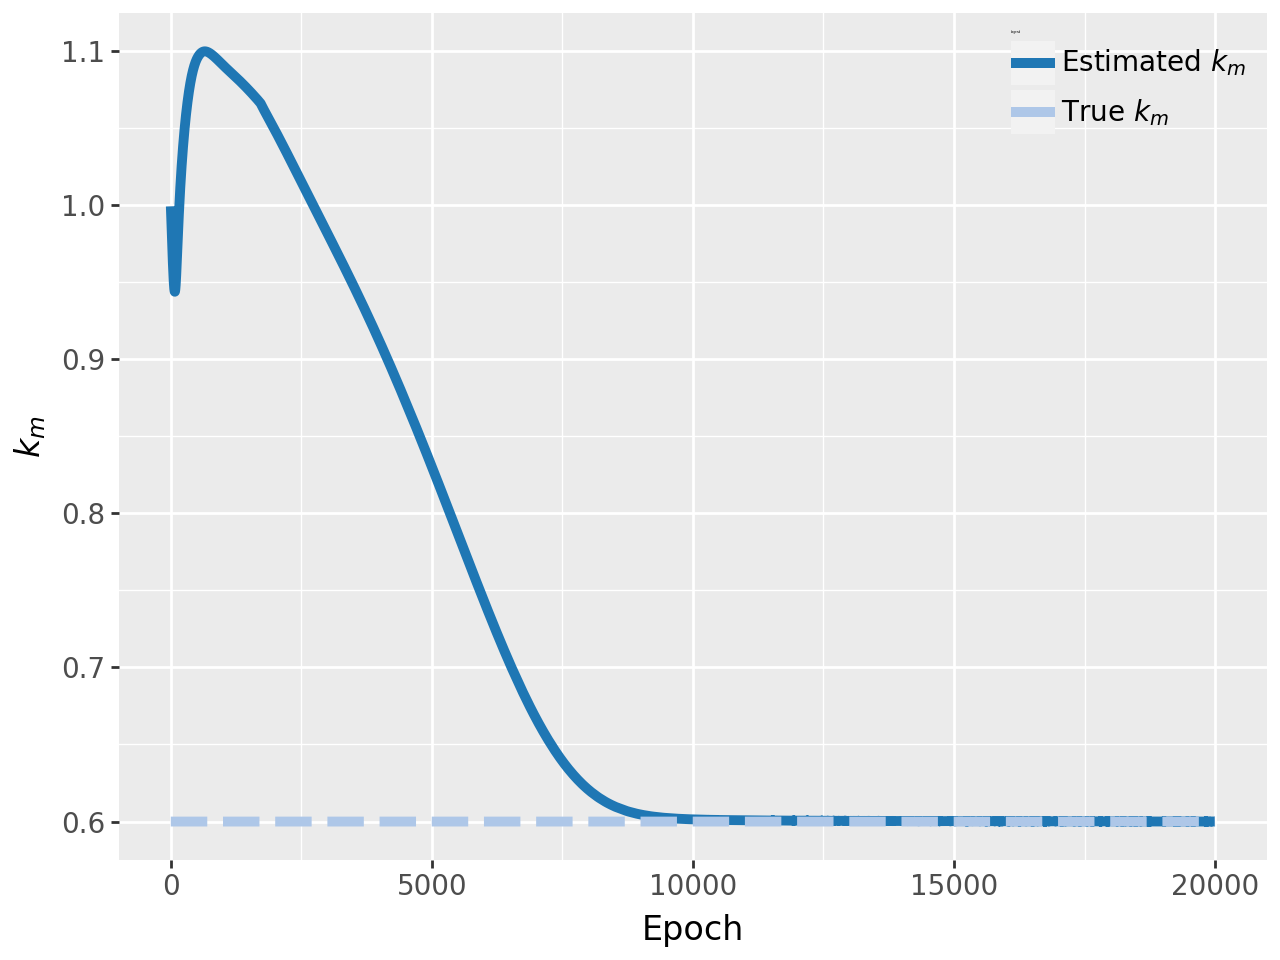

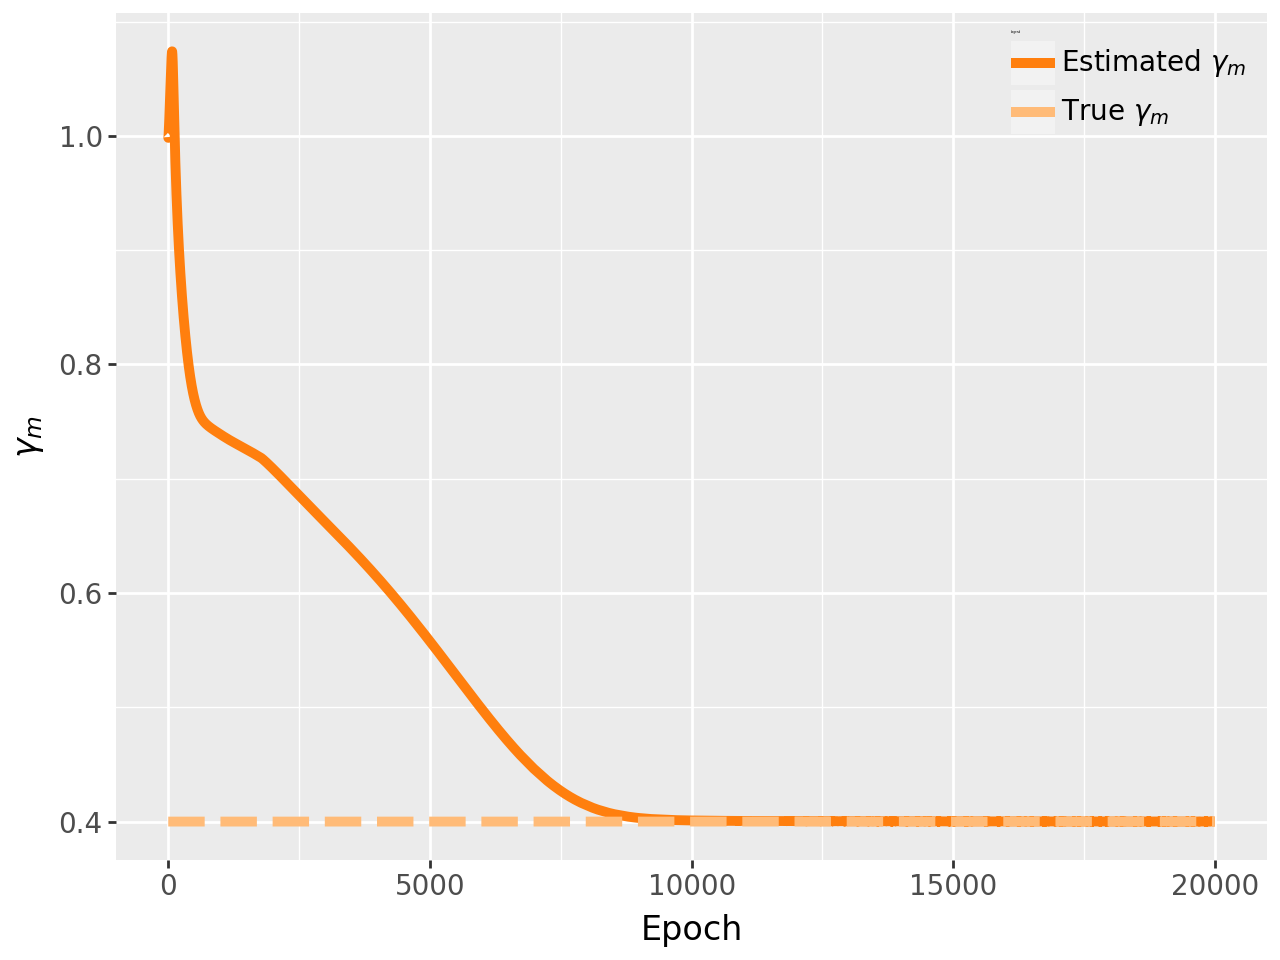

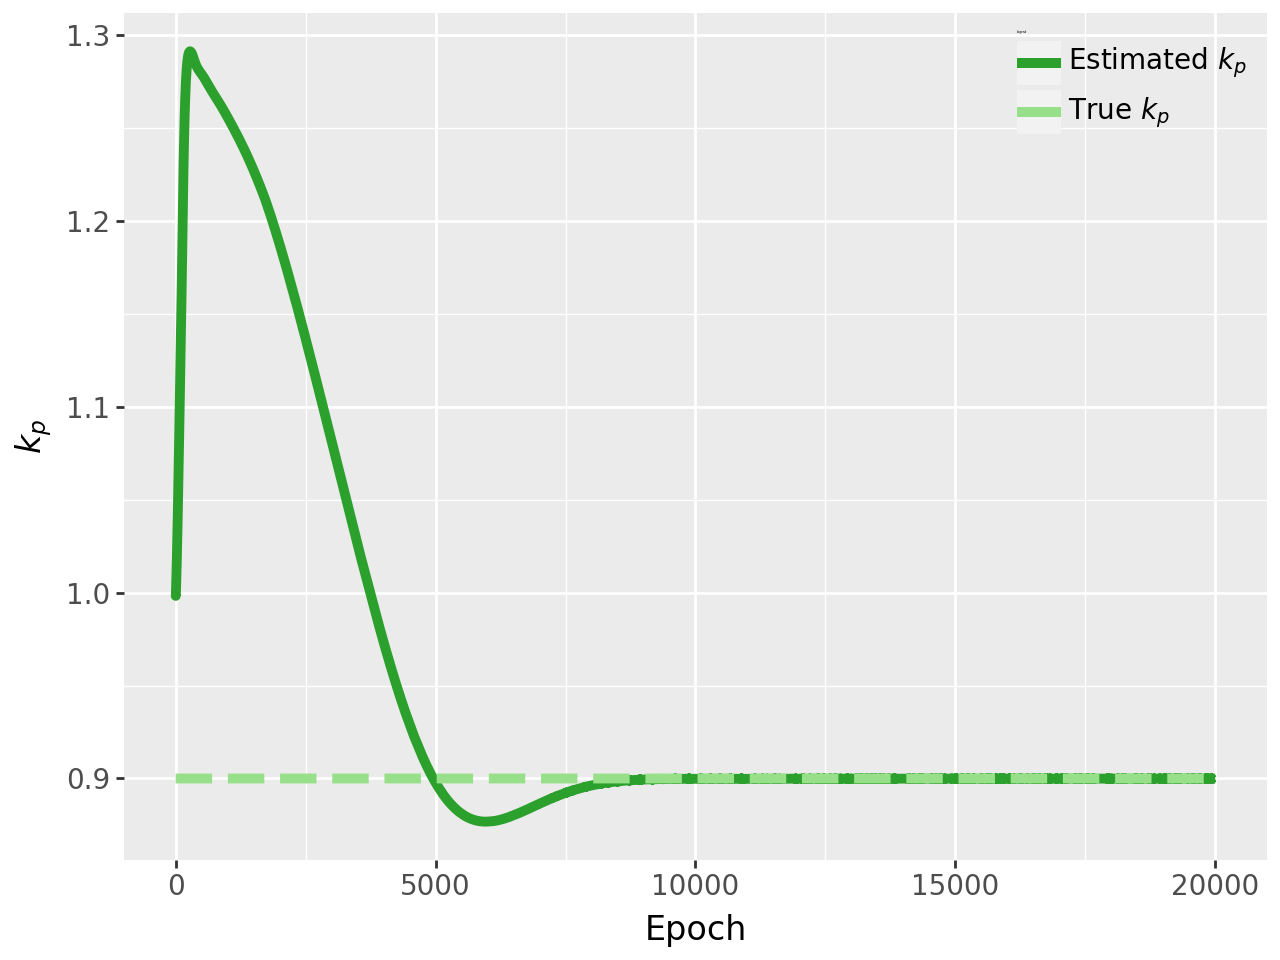

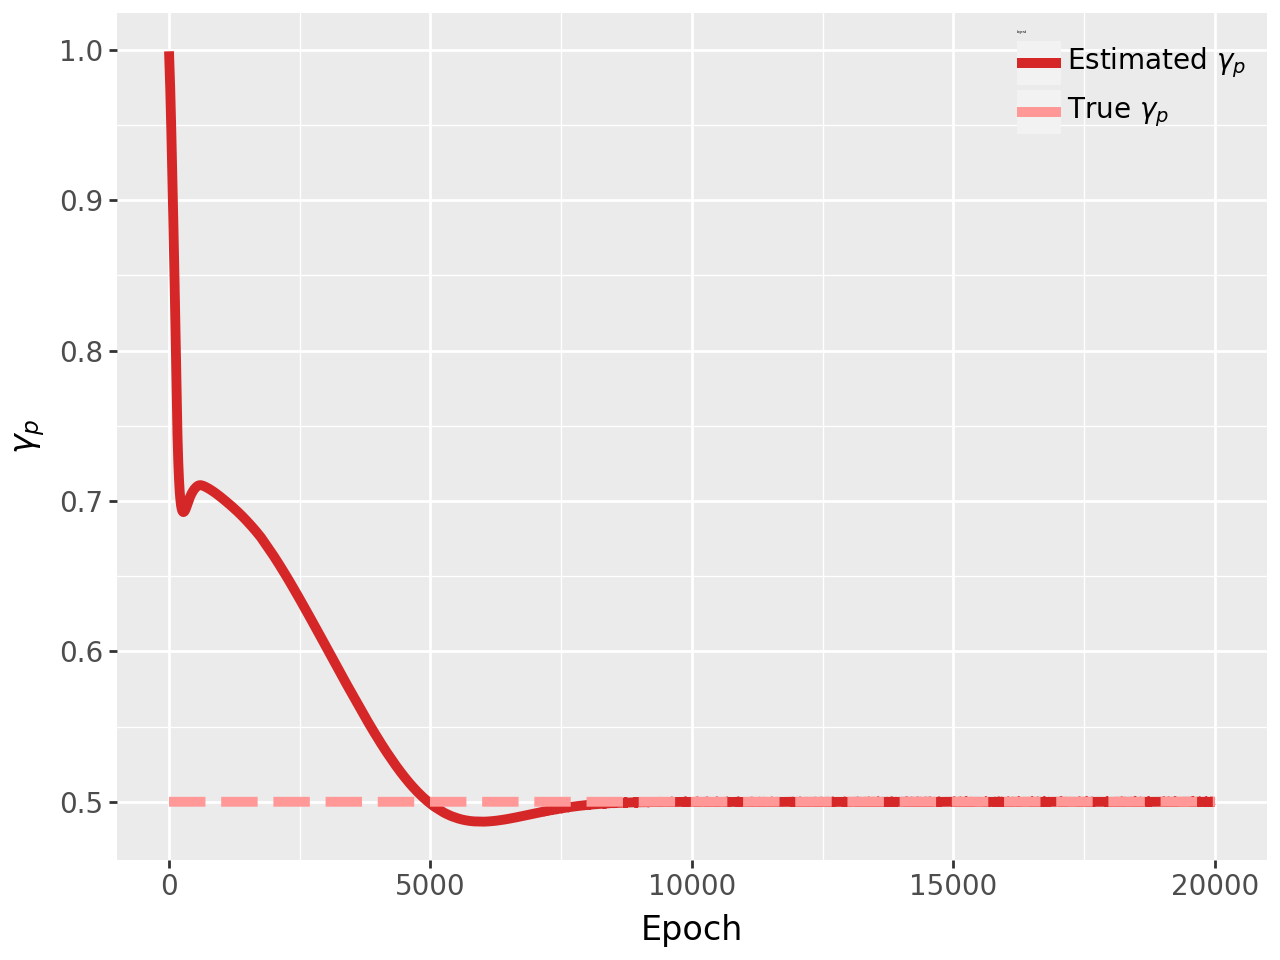

In [12]:
import torch
import torch.optim as optim
from model import PINN
import torch.nn as nn
from data_utils import simulate_data, load_and_prepare_data
from train import prepare_dataloader, train_with_physics_loss,to_tensor
# from plot_utils import plot_training_results, plot_results
from parameter_estimation import train_with_physics_loss_IP, PINN_IP
from GE_plot_utils import *

import warnings
warnings.filterwarnings("ignore")

def main():
# Define true parameters
    true_params = {
        'k_m': 0.6,
        'gamma_m': 0.4,
        'k_p': 0.9,
        'gamma_p': 0.5
    }

        

    # Load and prepare data
    t_train_set, t_test_set, data_m_train_set, data_p_train_set, data_m_test_set, data_p_test_set = load_and_prepare_data()

    # Define device and batch size
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 32

    # Prepare DataLoader
    train_loader = prepare_dataloader(t_train_set, data_m_train_set, data_p_train_set, batch_size, device)

    # Define the architecture and training parameters
    input_dim = 1
    hidden_dims = [100, 100]  # Number of neurons in hidden layers
    output_dim = 2  # Two outputs: mRNA and protein
    patience = 1500  # Number of epochs to wait for improvement
    epochs = 20000  # Number of training epochs
    lr = 0.001  # Learning rate for the optimizer


    # Instantiate the model and optimizer
    model_with_physics = PINN_IP(input_dim, hidden_dims, output_dim).to(device)
    optimizer_with_physics = optim.Adam(model_with_physics.parameters(), lr=lr)

    # Convert data to tensors
    t_train_tensor = to_tensor(t_train_set, device, requires_grad=True)
    data_m_train_tensor = to_tensor(data_m_train_set, device)
    data_p_train_tensor = to_tensor(data_p_train_set, device)

    # Train the model and get the training results
    history_with_physics, train_losses_with_physics, parameter_estimates = train_with_physics_loss_IP(
        model_with_physics, optimizer_with_physics, epochs, patience,
        t_train_tensor, data_m_train_tensor, data_p_train_tensor
    )

    

    # Plot parameter estimates and true values
    plot_parameters_IP(parameter_estimates, true_params, epochs)


if __name__ == "__main__":
    main()

